In [2]:
import pandas as pd
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import numpy as np
from sklearn.model_selection import train_test_split
import ipynb.fs.full.features as features
import ipynb.fs.full.utils as utils
from hyperopt import fmin, tpe, hp
from sklearn.metrics import mean_absolute_error
import ipynb.fs.full.features_distancias as f_distancias

df_train = pd.read_csv('./data/train_filtrado.csv')
df_test = pd.read_csv('./data/test.csv')

df_train = features.llenar_nulls(df_train)
df_test = features.llenar_nulls(df_test)

### Agrego Features

In [3]:

df_test_f = features.features_independientes_precio(df_test)
df_test_f = features.features_dependientes_precio(df_test_f, df_train)

df_train_f = features.features_independientes_precio(df_train)
df_train_f = features.features_dependientes_precio(df_train_f, df_train)

df_test_f, cols_tipodepropiedad_ohe = features.columna_a_ohe(df_test_f, 'tipodepropiedad', N=100, df_aux=df_train, devolver_cols=True)
df_test_f, cols_provincia_ohe = features.columna_a_ohe(df_test_f, 'provincia', N=100, df_aux=df_train, devolver_cols=True)
df_test_f, cols_zona_ohe = features.columna_a_ohe(df_test_f, 'zona', df_aux=df_train_f, devolver_cols=True)

df_train_f = features.columna_a_ohe(df_train_f, 'tipodepropiedad', N=100, df_aux=df_test)
df_train_f = features.columna_a_ohe(df_train_f, 'provincia', N=100, df_aux=df_test)
df_train_f = features.columna_a_ohe(df_train_f, 'zona', df_aux=df_test_f)


df_train_f['fecha'] = pd.to_datetime(df_train_f['fecha']).astype(int)
df_test_f['fecha'] = pd.to_datetime(df_test_f['fecha']).astype(int)

# df_train_f = df_train_f.sample(frac=1).reset_index(drop=True)

df_train_f = f_distancias.feature_distancias(df_train_f)
df_test_f = f_distancias.feature_distancias(df_test_f, df_train_f)

df_train_f = features.rankings(df_train_f, df_train_f)
df_test_f = features.rankings(df_test_f, df_train_f)

### Filtro columnas

In [5]:
list(df_train_f.columns)

['id',
 'titulo',
 'descripcion',
 'tipodepropiedad',
 'direccion',
 'ciudad',
 'provincia',
 'antiguedad',
 'habitaciones',
 'garages',
 'banos',
 'metroscubiertos',
 'metrostotales',
 'idzona',
 'lat',
 'lng',
 'fecha',
 'gimnasio',
 'usosmultiples',
 'piscina',
 'escuelascercanas',
 'centroscomercialescercanos',
 'precio',
 'metrostotales_log',
 'metroscubiertos_log',
 'porcentaje_metros',
 'diferencia_metros',
 'intervalo_metros_totales',
 'intervalo_metros_cubiertos',
 'metroscubiertos_bins_unif',
 'metroscubiertos_bins_perc',
 'escomercial',
 'promedio_metros_tipo_propiedad',
 'promedio_metros_cub_tipo_propiedad',
 'tipo_propiedad_compartida',
 'prop_frecuente',
 'zona',
 'top_provincia',
 'es_ciudad_centrica',
 'promedio_metros_totales_provincia',
 'promedio_metros_cubiertos_provincia',
 'anio',
 'mes',
 'dia',
 'trimestre',
 'dias_desde_datos',
 'meses_desde_datos',
 'escualas_centros_cercanos',
 'delincuencia',
 'turismo',
 'es_antigua',
 'antiguedad_bins_unif',
 'antiguedad_b

In [7]:
features = ['antiguedad', 'habitaciones', 'garages', 'banos',
       'metroscubiertos', 'metrostotales', 'lat', 'lng',
       'gimnasio', 'usosmultiples', 'piscina']

features_test = ['prop_frecuente', 'top_provincia', 'porcentaje_metros', 'diferencia_metros', 'promedio_precio_ciudad', 
                 'promedio_por_mes', 'anio', 'promedio_id_zona', 'promedio_precio_tipo_propiedad', 
                 'promedio_precio_hbg_tipo_propiedad', 'count_id_zona', 'count_ciudad', 'puntaje', 
                 'count_tipo_propiedad', 'count_tipo_propiedad_ciudad', 
                 'promedio_precio_tipo_propiedad_ciudad_gen', 'promedio_precio_hbg_tipo_propiedad_provincia',
                 'varianza_id_zona', 'tam_ambientes','dias_desde_datos','distancia_ciudad_centrica',
                 'distancia_centro_mexico',  'distancia_ciudad_cara', 'ranking_en_provincia_tipodepropiedad_precio',
                 ]

features += features_test

df_XGBoost, df_eval = utils.dividir_df_testeo(df_train_f, test_size=0.15)

df_XGBoost = utils.filtrar_features(df_XGBoost, features, 'precio')
df_eval = utils.filtrar_features(df_eval, features, 'precio')

## Busco los mejores hiperparametros

In [ ]:
def xgb_eval(args):
    
    # Modelo - Ver hiperparametros
    colsample_bytree, learning_rate, max_depth, alpha, n_estimators, test_size = args
    
    # Preparacion de los datos
    x_train, x_test, y_train, y_test = utils.dividir_dataset(df_XGBoost, 'precio', features, test_size=test_size)
    
    x_eval = df_eval.drop('precio', axis=1)
    y_eval = df_eval['precio']
    
    xg_train = xgb.DMatrix(x_train, label=y_train)
    xg_test = xgb.DMatrix(x_test, label=y_test)
    dfg_test = xgb.DMatrix(x_eval, label = y_eval)

    max_depth = int(max_depth)
    n_estimators = int(n_estimators)
    params = {
        'objective':'reg:squarederror', 
        'colsample_bytree' : colsample_bytree , 
        'learning_rate' : learning_rate,
        'max_depth' : max_depth, 
        'alpha' : alpha,
        'n_estimators' : n_estimators,
        'eval_metric': 'mae'
    }

    watchlist = [(xg_train, 'train'), (xg_test, 'test')]
    num_round = 25
    
    xg_reg = xgb.train(params, 
                    xg_train, 
                    num_round, 
#                     watchlist
                   )

    y_pred_eval = xg_reg.predict(dfg_test)
    y_pred_test = xg_reg.predict(xg_test)
    return utils.MAE(y_eval, y_pred_eval)

space = [hp.quniform('colsample_bytree', 0.3, 1, 0.05), hp.quniform('learning_rate', 0.01, 0.15, 0.01),
         hp.quniform("max_depth", 1, 20, 1),hp.uniform("alpha", 0.01, 30),
        hp.quniform("n_estimators", 100, 600, 30), hp.quniform("test_size", 0.1, 0.4, 0.05)]

hps = fmin(xgb_eval, space=space, algo=tpe.suggest, max_evals=50)

display(hps)

### Busco los mejores features

In [ ]:
features = ['antiguedad', 'habitaciones', 'garages', 'banos',
       'metroscubiertos', 'metrostotales', 
            # 'lat', 'lng',
       'gimnasio', 'usosmultiples', 'piscina', 'escuelascercanas', 'centroscomercialescercanos']

features_test = ['tipo_propiedad_compartida',
                 'prop_frecuente', 'top_provincia', 'es_ciudad_centrica',
                 'promedio_metros_totales_provincia',
                 'promedio_metros_cubiertos_provincia', 'porcentaje_metros',
                 'diferencia_metros', 'delincuencia', 'turismo',
                 'promedio_precio_ciudad', 'promedio_id_zona',
                 'promedio_precio_tipo_propiedad','es_antigua',
                 'promedio_por_mes', 'promedio_precio_habitaciones',
                 'promedio_precio_habitaciones_banos_garages','cantidad_inquilinos',
                 'promedio_precio_banos_garages', 'promedio_precio_booleanos',
                 'metros_totales_normalizados', 'metros_cubiertos_normalizados','escomercial',
                 'promedio_metros_cub_tipo_propiedad', 'anio', 'mes', 'dia','trimestre']


In [ ]:
hps = {'alpha': 9.499855511978337,
 'colsample_bytree': 0.8500000000000001,
 'learning_rate': 0.2226513740962932,
 'max_depth': 20.0,
 'n_estimators': 240.0,
 'test_size': 0.103950169925154826
}

alpha = hps['alpha']
colsample_bytree = hps['colsample_bytree']
max_depth = hps['max_depth']
learning_rate = hps['learning_rate']
n_estimators = hps['n_estimators']

n_estimators = int(hps['n_estimators'])
max_depth = int(hps['max_depth'])

params = {
        'objective':'reg:squarederror', 
        'colsample_bytree' : colsample_bytree , 
        'learning_rate' : learning_rate,
        'max_depth' : max_depth, 
        'alpha' : alpha,
        'n_estimators' : n_estimators,
        'eval_metric': 'mae'
}


base_train = 0
base_test = 0
base_eval = 0
for i in ['None'] + features_test:
    x_train, x_test, y_train, y_test = utils.dividir_dataset(df_train_f, 'precio', features + [i])

    xg_train = xgb.DMatrix(x_train, label=y_train)
    xg_test = xgb.DMatrix(x_test, label=y_test)
    xg_train = xgb.DMatrix(x_train, label=y_train)
    xg_test = xgb.DMatrix(x_test, label=y_test)

    watchlist = [(xg_train, 'train'), (xg_test, 'test')]
    num_round = 10
    
    xg_reg = xgb.train(params, 
                    xg_train, 
                    num_round, 
                    watchlist
                   )
    
    x_train_predict = xgb.DMatrix(x_train, label=y_train)
    x_test_predict = xgb.DMatrix(x_test, label=y_test)
    x_eval_predict = xgb.DMatrix(utils.filtrar_features(df_eval, features + [i]))
    
    y_pred_test = xg_reg.predict(x_test_predict)
    y_pred_train = xg_reg.predict(x_train_predict)
    y_pred_eval = xg_reg.predict(x_eval_predict)

    xgb_mae_train = utils.MAE(y_train, y_pred_train)
    xgb_mae = utils.MAE(y_test, y_pred_test)
    xgb_mae_eval = utils.MAE(df_eval['precio'].values, y_pred_eval)

    print(f"MAE LightGBM (train): {xgb_mae_train:.5f}")
    print(f"MAE LightGBM (test): {xgb_mae:.5f}")
    print(f"MAE LightGBM (eval): {xgb_mae_eval:.5f}")
    if i is not 'None':
        print(f"Overfitting (base_eval - base_test) - (eval - test) - {i}: {(base_eval - base_test) - (xgb_mae_eval - xgb_mae)}")
        print(f"Diff evaluation (base_eval - eval)                  - {i}: {base_eval - xgb_mae_eval}")
        print(f"Diff train (base_train - train)                     - {i}: {base_train - xgb_mae_train}")
    else:
        base_train = xgb_mae_train
        base_test = xgb_mae
        base_eval = xgb_mae_eval


### Gráfico

[0]	validation_0-error:-2.53066e+06	validation_0-mae:2.18414e+06	validation_1-error:-2.49884e+06	validation_1-mae:2.15786e+06
[1]	validation_0-error:-2.53066e+06	validation_0-mae:1.88652e+06	validation_1-error:-2.49884e+06	validation_1-mae:1.86603e+06
[2]	validation_0-error:-2.53066e+06	validation_0-mae:1.63149e+06	validation_1-error:-2.49884e+06	validation_1-mae:1.61723e+06
[3]	validation_0-error:-2.53066e+06	validation_0-mae:1.41194e+06	validation_1-error:-2.49884e+06	validation_1-mae:1.40799e+06
[4]	validation_0-error:-2.53066e+06	validation_0-mae:1.22238e+06	validation_1-error:-2.49884e+06	validation_1-mae:1.22933e+06
[5]	validation_0-error:-2.53066e+06	validation_0-mae:1.06007e+06	validation_1-error:-2.49884e+06	validation_1-mae:1.08088e+06
[6]	validation_0-error:-2.53066e+06	validation_0-mae:921399	validation_1-error:-2.49884e+06	validation_1-mae:959366
[7]	validation_0-error:-2.53066e+06	validation_0-mae:802124	validation_1-error:-2.49884e+06	validation_1-mae:858375
[8]	validati

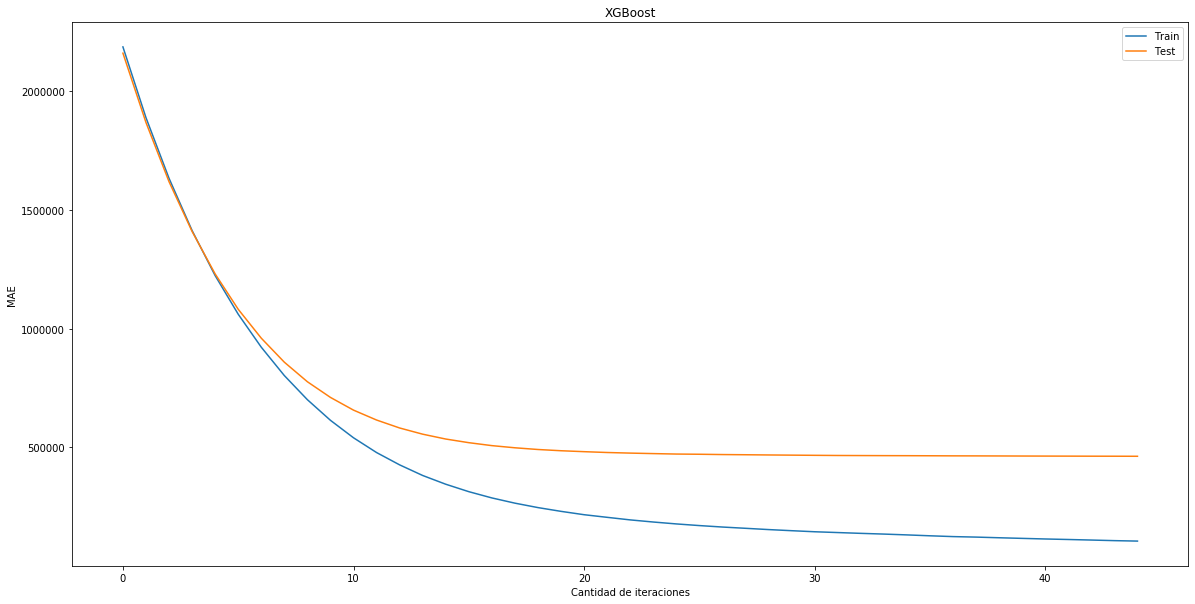

In [33]:
from numpy import loadtxt
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from matplotlib import pyplot

features = ['antiguedad', 'habitaciones', 'garages', 'banos',
       'metroscubiertos', 'metrostotales', 'lat', 'lng',
       'gimnasio', 'usosmultiples', 'piscina']

features_test = ['prop_frecuente', 'top_provincia', 'porcentaje_metros', 'diferencia_metros', 'promedio_precio_ciudad', 
                 'promedio_por_mes', 'anio', 'promedio_id_zona', 'promedio_precio_tipo_propiedad', 
                 'promedio_precio_hbg_tipo_propiedad', 'count_id_zona', 'count_ciudad', 'puntaje', 
                 'count_tipo_propiedad', 'count_tipo_propiedad_ciudad', 
                 'promedio_precio_tipo_propiedad_ciudad_gen', 'promedio_precio_hbg_tipo_propiedad_provincia',
                 'varianza_id_zona', 'tam_ambientes','dias_desde_datos','distancia_ciudad_centrica',
                 'distancia_centro_mexico',  'distancia_ciudad_cara', 'ranking_en_provincia_tipodepropiedad_precio',
                 ]

features += features_test

# hps = {'alpha': 12.338515720263425,
#  'colsample_bytree': 0.8500000000000001,
#  'learning_rate': 0.15,
#  'max_depth': 17.0,
#  'n_estimators': 300.0,
#  'test_size': 0.15000000000000002}

hps = {'verbosity': 0,
 'objective': 'reg:squarederror',
 'eval_metric': 'mae',
 'n_estimators': 45,
 'n_jobs': 4,
 'reg_alpha': 20.91434940058063,
 'colsample_bytree': 0.65,
 'learning_rate': 0.14,
 'max_depth': int(16.0)}


# colsample_bytree = hps['colsample_bytree']
# max_depth = hps['max_depth']
# learning_rate = hps['learning_rate']
# n_estimators = hps['n_estimators']
# n_estimators = int(hps['n_estimators'])
# max_depth = int(hps['max_depth'])


# Preparacion de los datos
x_train, x_test, y_train, y_test = utils.dividir_dataset(df_XGBoost, 'precio', features, test_size=0.15)

xg_reg = xgb.XGBRegressor(**hps)


eval_set = [(x_train, y_train), (x_test, y_test)]
xg_reg.fit(x_train, y_train, eval_metric=["error","mae"], eval_set=eval_set, verbose=True)

# x_eval = df_eval.drop('precio', axis=1)
# y_eval = df_eval['precio']

# xg_train = xgb.DMatrix(x_train, label=y_train)
# xg_test = xgb.DMatrix(x_test, label=y_test)
# dfg_test = xgb.DMatrix(x_eval, label = y_eval)


# params = {
#     'objective':'reg:squarederror', 
#     'colsample_bytree' : colsample_bytree , 
#     'learning_rate' : learning_rate,
#     'max_depth' : max_depth, 
#     'n_estimators' : n_estimators,
#     'eval_metric': 'mae'
# }

# watchlist = [(xg_train, 'train'), (xg_test, 'test')]

# # Entrenamiento
# xg_reg = xgb.train(params, 
#                    xg_train, 
#                    num_boost_round=5,
#                    evals=watchlist)

# Prediccion
# y_pred_train = xg_reg.predict(xg_train)
# y_pred_test = xg_reg.predict(xg_test)

# y_pred_train = xg_reg.predict(x_train)
y_pred_test = xg_reg.predict(x_test)


predictions = [round(value) for value in y_pred_test]
# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
# retrieve performance metrics
results = xg_reg.evals_result()
epochs = len(results['validation_0']['error'])
x_axis = range(0, epochs)
# plot log loss
fig, ax = pyplot.subplots(figsize=(20,10))
ax.plot(x_axis, results['validation_0']['mae'], label='Train')
ax.plot(x_axis, results['validation_1']['mae'], label='Test')
ax.legend()
pyplot.xlabel('Cantidad de iteraciones')
pyplot.ylabel('MAE')
pyplot.title('XGBoost')
pyplot.show()


## Predicción

[0]	validation_0-error:-2.53066e+06	validation_0-mae:2.18414e+06	validation_1-error:-2.49884e+06	validation_1-mae:2.15786e+06
[1]	validation_0-error:-2.53066e+06	validation_0-mae:1.88652e+06	validation_1-error:-2.49884e+06	validation_1-mae:1.86603e+06
[2]	validation_0-error:-2.53066e+06	validation_0-mae:1.63149e+06	validation_1-error:-2.49884e+06	validation_1-mae:1.61723e+06
[3]	validation_0-error:-2.53066e+06	validation_0-mae:1.41194e+06	validation_1-error:-2.49884e+06	validation_1-mae:1.40799e+06
[4]	validation_0-error:-2.53066e+06	validation_0-mae:1.22238e+06	validation_1-error:-2.49884e+06	validation_1-mae:1.22933e+06
[5]	validation_0-error:-2.53066e+06	validation_0-mae:1.06007e+06	validation_1-error:-2.49884e+06	validation_1-mae:1.08088e+06
[6]	validation_0-error:-2.53066e+06	validation_0-mae:921399	validation_1-error:-2.49884e+06	validation_1-mae:959366
[7]	validation_0-error:-2.53066e+06	validation_0-mae:802124	validation_1-error:-2.49884e+06	validation_1-mae:858375
[8]	validati

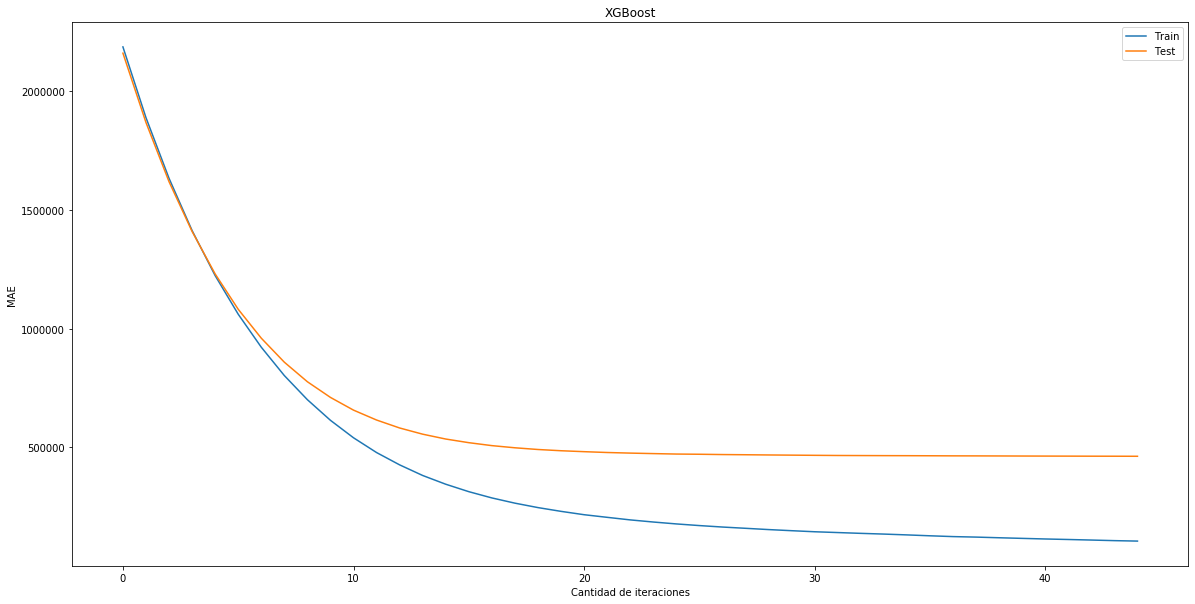

In [31]:
features = ['antiguedad', 'habitaciones', 'garages', 'banos',
       'metroscubiertos', 'metrostotales', 
            'lat', 'lng',
       'gimnasio', 'usosmultiples', 'piscina', 'escuelascercanas', 'centroscomercialescercanos']


# Preparación hiperparámetros

# hps = {'alpha': 12.338515720263425,
#  'colsample_bytree': 0.8500000000000001,
#  'learning_rate': 0.15,
#  'max_depth': 17.0,
#  'n_estimators': 300.0,
#  'test_size': 0.15000000000000002}

hps = {'alpha': 19.99916025229205,
 'colsample_bytree': 0.65,
 'learning_rate': 0.15,
 'max_depth': int(20.0),
 'n_estimators': int(90.0),
 'test_size': 0.1}

alpha = hps['alpha']
colsample_bytree = hps['colsample_bytree']
max_depth = hps['max_depth']
learning_rate = hps['learning_rate']
n_estimators = hps['n_estimators']
test_size = hps['test_size']

n_estimators = int(hps['n_estimators'])
max_depth = int(hps['max_depth'])


# Preparacion de los datos
x_train, x_test, y_train, y_test = utils.dividir_dataset(df_XGBoost, 'precio', features, test_size=test_size)

x_eval = df_eval.drop('precio', axis=1)
y_eval = df_eval['precio']

xg_train = xgb.DMatrix(x_train, label=y_train)
xg_test = xgb.DMatrix(x_test, label=y_test)
dfg_test = xgb.DMatrix(x_eval, label = y_eval)

evals_result = {}

params = {
    'objective':'reg:squarederror', 
    'colsample_bytree' : colsample_bytree , 
    'learning_rate' : learning_rate,
    'max_depth' : max_depth, 
    'alpha' : alpha,
    'n_estimators' : n_estimators,
    'eval_metric': 'mae'
}

watchlist = [(xg_train, 'train'), (xg_test, 'test')]

# Entrenamiento
xg_reg = xgb.train(params, 
                   xg_train, 
                   num_boost_round=5,
                   evals_result = evals_result,
                   evals=watchlist)

# Prediccion
y_pred_train = xg_reg.predict(xg_train)
y_pred_test = xg_reg.predict(xg_test)


linear_mae_train = utils.MAE(y_train, y_pred_train)
linear_mae = utils.MAE(y_test, y_pred_test)

y_pred_eval = xg_reg.predict(dfg_test)
linear_mae_eval = utils.MAE(y_eval, y_pred_eval)


print(f"MAE (train): {linear_mae_train:.5f}")
print(f"MAE: {linear_mae:.5f}")
print(f"MAE (eval): {linear_mae_eval:.5f}")



## Predicción final

In [ ]:
df_train_final = pd.read_csv('./data/train.csv')
df_test_final = pd.read_csv('./data/test.csv')

df_train_final = features.llenar_nulls(df_train_final)
df_test_final = features.llenar_nulls(df_test_final)

df_train_final_f = features.features_independientes_precio(df_train_final)
df_train_final_f = features.features_dependientes_precio(df_train_final_f, df_train_final)
df_test_final_f = features.features_independientes_precio(df_test_final)
df_test_final_f = features.features_dependientes_precio(df_test_final_f, df_train_final)

df_test_final_f, cols_tipodepropiedad_ohe = features.columna_a_ohe(df_test_final_f, 'tipodepropiedad', N=100, df_aux=df_train_final, devolver_cols=True)
df_test_final_f, cols_provincia_ohe = features.columna_a_ohe(df_test_final_f, 'provincia', N=100, df_aux=df_train_final, devolver_cols=True)
df_test_final_f, cols_zona_ohe = features.columna_a_ohe(df_test_final_f, 'zona', df_aux=df_train_final_f, devolver_cols=True)

df_train_final_f = features.columna_a_ohe(df_train_final_f, 'tipodepropiedad', N=100, df_aux=df_test_final)
df_train_final_f = features.columna_a_ohe(df_train_final_f, 'provincia', N=100, df_aux=df_test_final)
df_train_final_f = features.columna_a_ohe(df_train_final_f, 'zona', df_aux=df_test_final_f)

df_train_final_f['fecha'] = pd.to_datetime(df_train_final_f['fecha']).astype(int)
df_test_final_f['fecha'] = pd.to_datetime(df_test_final_f['fecha']).astype(int)

In [ ]:
features = ['antiguedad', 'habitaciones', 'garages', 'banos',
       'metroscubiertos', 'metrostotales', 
            'lat', 'lng',
       'gimnasio', 'usosmultiples', 'piscina', 'escuelascercanas', 'centroscomercialescercanos']

features_test = ['prop_frecuente', 'top_provincia', 'porcentaje_metros', 'diferencia_metros', 'promedio_precio_ciudad', 
                 'promedio_por_mes', 'anio', 'promedio_id_zona', 'promedio_precio_tipo_propiedad', 
                 'promedio_precio_hbg_tipo_propiedad', 'count_id_zona', 'count_ciudad', 'puntaje', 
                 'count_tipo_propiedad', 'count_tipo_propiedad_ciudad', 
                 'promedio_precio_tipo_propiedad_ciudad_gen', 'promedio_precio_hbg_tipo_propiedad_provincia',
                 'varianza_id_zona', 'tam_ambientes', 'metros_cubiertos_normalizados', 'dias_desde_datos',
                 'meses_desde_datos', 'promedio_id_zona_log']

features += features_test

features += cols_tipodepropiedad_ohe + cols_provincia_ohe + cols_zona_ohe


hps = {'alpha': 19.99916025229205,
 'colsample_bytree': 0.65,
 'learning_rate': 0.15,
 'max_depth': int(20.0),
 'n_estimators': int(90.0),
 'test_size': 0.1}

alpha = hps['alpha']
colsample_bytree = hps['colsample_bytree']
max_depth = hps['max_depth']
learning_rate = hps['learning_rate']
n_estimators = hps['n_estimators']
test_size = hps['test_size']

n_estimators = int(hps['n_estimators'])
max_depth = int(hps['max_depth'])


# Filtro columnas
df_XGBoost_fin = utils.filtrar_features(df_train_final_f, features, 'precio')
df_eval_fin = utils.filtrar_features(df_test_final_f, features)

x_train_f, x_test_f, y_train_f, y_test_f = utils.dividir_dataset(df_XGBoost_fin, 'precio', features)


xg_train = xgb.DMatrix(x_train_f, label=y_train_f)
xg_test = xgb.DMatrix(x_test_f, label=y_test_f)

# Modelo - Ver hiperparametros
params = {
    'objective':'reg:squarederror', 
    'colsample_bytree' : colsample_bytree , 
    'learning_rate' : learning_rate,
    'max_depth' : max_depth, 
    'alpha' : alpha,
    'n_estimators' : n_estimators,
    'eval_metric': 'mae'
}

watchlist = [(xg_train, 'train'), (xg_test, 'test')]

# Entrenamiento
xg_reg = xgb.train(params, 
                   xg_train, 
                   num_boost_round=400,
                   evals=watchlist,
                   early_stopping_rounds=10
                  )


# Prediccion
y_pred_test_f = xg_reg.predict(xgb.DMatrix(x_test_f))
y_pred_train_f = xg_reg.predict(xgb.DMatrix(x_train_f))

linear_mae_train_f = utils.MAE(y_train_f, y_pred_train_f)
linear_mae_f = utils.MAE(y_test_f, y_pred_test_f)



print(f"MAE (train): {linear_mae_train_f:.5f}")
print(f"MAE: {linear_mae_f:.5f}")

prediccion_final = xg_reg.predict(xgb.DMatrix(df_eval_fin))
df_test_final_f['target'] = prediccion_final
df_test_final_f[['id', 'target']].to_csv('respuesta22.csv', index = False)

### Verificación de Nulos

In [ ]:
df_test_final_f['target'].isnull().any()

In [ ]:
df_test_final_f['target'].isnull().value_counts()

In [ ]:
x_train_f.columns